# Transfer learning with TensorFlow/Keras 2.0 

In this example we'll implement fine-tuning and feature extracting transfer learning using the CIFAR-10 dataset. 

_This example is partially based on_ [https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb]

Let's start with the imports:

In [3]:
!pip install tensorflow_datasets

  Created wheel for dill: filename=dill-0.3.2-py3-none-any.whl size=78977 sha256=6e8a5b1cfdd376b942ca6c651ec9e9b6fafc55e2ae4cd3f52eacc8935a5c1030
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\72\6b\d5\5548aa1b73b8c3d176ea13f9f92066b02e82141549d90e2100
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491062 sha256=e230024d34b8ea02d660f54a8feb1986c1400627096493c49e50d29ddc7ea2af
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\56\b0\fe\4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21499 sha256=8789622dcf54d885ca9dc753cf52323170bde9e4a2c37109608d37d42cfdcd5d
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\29\93\c6\762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
Successfully built dill future promise


ERROR: tensorflow-metadata 0.23.0 has requirement absl-py<0.9,>=0.7, but you'll have absl-py 0.9.0 which is incompatible.


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

We'll define the input image and batch size as constants:

In [6]:
IMG_SIZE = 224  #don't change this !!!
BATCH_SIZE = 50

We'll continue by loading the CIFAR-10 dataset using the `tensorflow_datasets` package:

In [8]:
data, metadata = tfds.load('cifar10', with_info=True, as_supervised=True)

raw_train, raw_test = data['train'].repeat(), data['test'].repeat()

Shuffling and writing examples to C:\Users\dell\tensorflow_datasets\cifar10\3.0.2.incompleteO23IZS\cifar10-train.tfrecord


Shuffling and writing examples to C:\Users\dell\tensorflow_datasets\cifar10\3.0.2.incompleteO23IZS\cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to C:\Users\dell\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.


Next, we'll define the input transformations (per sample) for the training and validation phases:

In [9]:
def train_format_sample(image, label):
    """Transform data for training"""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image / 127.5) - 1
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    label = tf.one_hot(label, metadata.features['label'].num_classes)

    return image, label


def test_format_sample(image, label):
    """Transform data for testing"""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image / 127.5) - 1

    label = tf.one_hot(label, metadata.features['label'].num_classes)

    return image, label

Then, we'll define the training and validation data providers:

In [12]:
# assign transformers to raw data
train_data = raw_train.map(train_format_sample)
test_data = raw_test.map(test_format_sample)

# extract batches from the training set
train_batches = train_data.shuffle(1000).batch(BATCH_SIZE)
test_batches = test_data.batch(BATCH_SIZE)

Next, we'll define 2 functions that build transfer learning models for either feature extacting, or fine-tuning. Both models use the `tf.keras.applications.ResNet50V2` ImageNet pretrained model. We'll start with feature extracting, which "locks" all model parameters (weights) except for the final fully-connected layer:

In [17]:
def build_fe_model():
    """"Create feature extraction model from the pre-trained model ResNet50V2"""

    # create the pre-trained part of the network, excluding FC layers
    base_model = tf.keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                  include_top=False,
                                                  weights='imagenet')

    # exclude all model layers from training
    base_model.trainable = False

    # create new model as a combination of the pre-trained net
    # and one fully connected layer at the top
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(
            metadata.features['label'].num_classes,
            activation='softmax')
    ])

We'll continue with the fine-tuning model, which locks the first `fine_tune_at` layers, but trains all other model parameters:

In [19]:
def build_ft_model():
    """"Create fine tuning model from the pre-trained model ResNet50V2"""

    # create the pre-trained part of the network, excluding FC layers
    base_model = tf.keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                  include_top=False,
                                                  weights='imagenet')

    # Fine tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # create new model as a combination of the pre-trained net
    # and one fully connected layer at the top
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(
            metadata.features['label'].num_classes,
            activation='softmax')
    ])

Let's define the `train_model` function, which builds takes the pre-built model, fits it over the training data, and plots the training and validation results. The function is shared for both feature extraction and fine-tuning:

In [20]:
def train_model(model, epochs=5):
    """Train the model. This function is shared for both FE and FT modes"""

    # configure the model for training
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    history = model.fit(train_batches,
                        epochs=epochs,
                        steps_per_epoch=metadata.splits['train'].num_examples // BATCH_SIZE,
                        validation_data=test_batches,
                        validation_steps=metadata.splits['test'].num_examples // BATCH_SIZE,
                        workers=4)

    # plot accuracy
    test_acc = history.history['val_accuracy']

    plt.figure()
    plt.plot(test_acc)
    plt.xticks(
        [i for i in range(0, len(test_acc))],
        [i + 1 for i in range(0, len(test_acc))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

We can now run the training procedure. Let's start by building the feature extraction model:

In [22]:
model = build_fe_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Next, let's run the training:

In [23]:
#50000/50 = 1000 >> n0. of iterations (steps) per epoch 
train_model(model)

Epoch 1/5
  44/1000 [>.............................] - ETA: 2:01:50 - loss: 2.4080 - accuracy: 0.1750

KeyboardInterrupt: 

We can also try the fine-tuning model for comparison:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,580,362
Non-trainable params: 3,004,928
_________________________________________________________________
Train for 1000 steps, validate for 200 steps
Epoch 1/5
1000/1000 [==============================] - 302s 302ms/step - loss: 0.4756 - accuracy: 0.8367 - val_loss: 0.4555 - val_accuracy: 0.8452
Epoch 2/5
1000/1000 [==============================] - 295s 295ms/step - loss: 0.2451 - accuracy: 0.9170 - val_loss: 0.4341 - val_accuracy: 0.8588
Epoch 3/5
1000/1000 [====

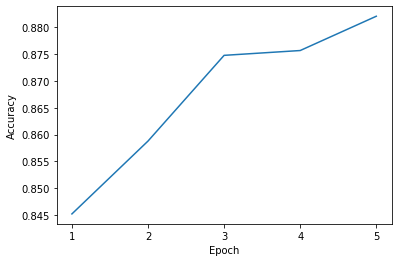

In [11]:
model = build_ft_model()
model.summary()
train_model(model)

Fine-tuning achieves better accuracy, compared to the feature-engineering model. The most likely reason is that the feature-engineering model is constrained to update only the weights of the last hidden layer.